In [256]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.integrate
from matplotlib import cm
from scipy import fft
from matplotlib.animation import FuncAnimation, PillowWriter 
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

In [257]:
# define some parameters 

alpha = .95
epsilon = .3
L = 2*np.pi
Ma = 0.
vol = 0.0001
I_0 = 10
remainder = Ma/I_0**2


In [261]:
#definitions and more parameters: 
alpha = .95; epsilon = .3; L = 2*np.pi; Ma = 0.5; vol = 0.1; I_0 = 1; remainder = Ma/I_0**2
I = 0.8
Ma = remainder*I**2
Ma = 0.5
print(Ma)

#definition of the RHS function

def RHS_not_stoch(time,eta):
    # build the n =[-Nx/2, ... , -1, 0,1, ..., Nx/2] vector 
    N = len(eta)
    n = np.arange(N);
    n[int(N/2)+1:] -= N
    
    # compute some derivatives
    eta_z = fft.ifft(n*1j*np.pi*2/L*fft.fft(eta))
    eta_zzz = fft.ifft((n*1j*np.pi*2/L)**3*fft.fft(eta))
    
    # compute the RHS
    detadt = -fft.ifft(n*1j*2*np.pi/L*fft.fft(eta**3*(1+(1-2*Ma)*eta_z+epsilon**2*eta_zzz))).real/3
    return detadt

#define the discretisations and the initial conditions
T = 10 #### final time
#k = round(np.sqrt((1-2*Ma)/2)/epsilon)
k = 2
print(k)
z = np.linspace(0, 2*np.pi,400)
t = np.linspace(0,T, 300)
t_eval = np.linspace(0,T, 10)
delta_t = t[1]-t[0]
t_span = (0,T)
u0 = (1.1 - np.sin(z*k))/2

mean_value = np.trapz(u0, z)/2/np.pi # some metrics

# integrate the system with a built in solver. 
# very important to specify 'BDF' in the arguments, to solve with a stiff method. 
#you can specify different tolerances if you want

result_ivp_determininistic = scipy.integrate.solve_ivp(RHS_not_stoch, t_span, u0, 'BDF', atol = 1e-3, t_eval =t)

u_det = result_ivp_determininistic.y # extract solution
print('Solved deterministic ,', np.shape(u_det)) #check solution is fully computed, 
#sometimes when convergence fails it stops halfway through


max_value_deterministic = np.max(u_det, axis=0)[-1]
print(max_value_deterministic)

0.5
2
Solved deterministic , (400, 300)
0.6889410030186566


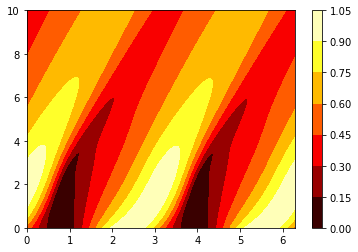

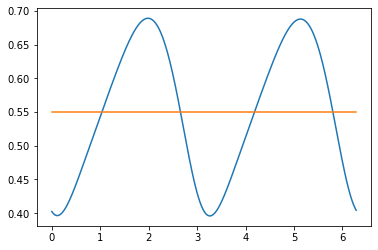

In [262]:
Z,T = np.meshgrid(z,t)
plt.contourf(Z,T, u_det.T, cmap='hot'); plt.colorbar()
plt.show()
plt.plot(z, u_det[:,-1])
plt.plot(z, np.ones_like(z)*mean_value)


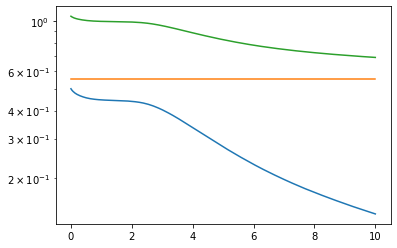

In [263]:
plt.semilogy(t, np.abs(np.max(u_det, axis=0)-mean_value))
plt.semilogy(t, np.ones_like(t)*mean_value)
plt.semilogy(t, np.abs(np.max(u_det, axis=0)))


In [137]:
#plt.plot(t, np.trapz(u_det,z, axis=0)/2/np.pi)
#np.trapz(u_det,z, axis=0)

In [128]:
#now we iterate
alpha = .95; epsilon = .1; L = 2*np.pi; Ma = 0.5; vol = 0.1; I_0 = 1; remainder = Ma/I_0**2

I_list = np.flip(np.linspace(0.5, 1.5, 30))

max_values_list = np.zeros_like(I_list)

T = 5
k = round(1/np.sqrt(2)/epsilon)
print(k)
Nt=100
z = np.linspace(0, 2*np.pi, 200)
t = np.linspace(0,T, Nt)
t_eval = np.linspace(0,T, 10)
delta_t = t[1]-t[0]

t_span = (0,T)
u0 = (1.1 - np.cos(z*k))/2 
mean_value = np.trapz(u0, z)/2/np.pi 
decay_array = np.zeros((Nt, len(I_list)))

N = len(u0)
n = np.arange(N);
n[int(N/2)+1:] -= N

for j, I in enumerate(I_list):
    Ma = remainder*I**2
    def RHS_not_stoch(time,eta):
        eta_z = fft.ifft(n*1j*np.pi*2/L*fft.fft(eta))
        eta_zzz = fft.ifft((n*1j*np.pi*2/L)**3*fft.fft(eta))
        detadt = -fft.ifft(n*1j*2*np.pi/L*fft.fft(eta**3*(1+(1-2*Ma)*eta_z+epsilon**2*eta_zzz))).real/3
        return detadt
    result_ivp_determininistic = scipy.integrate.solve_ivp(RHS_not_stoch, t_span, u0, 'BDF', atol = 1e-7, t_eval =t)
    max_values_list[j] = np.max(result_ivp_determininistic.y, axis=0)[-1]
    decay_array[:,j] = np.max(result_ivp_determininistic.y, axis=0)
    del result_ivp_determininistic
    del RHS_not_stoch
    if (j+1) % 5 == 0:
        print('Currently at ', int(100*(j+1)/len(I_list)), ' %')

    

7
Currently at  16  %
Currently at  33  %
Currently at  50  %


KeyboardInterrupt: 

0.55

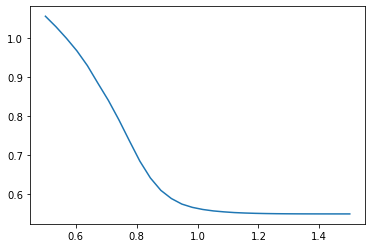

In [47]:
plt.plot(I_list, max_values_list)


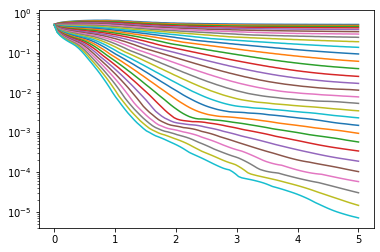

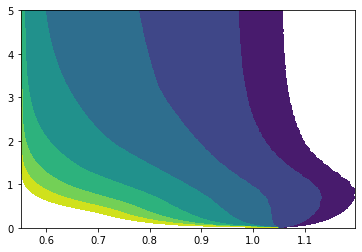

In [54]:
plt.semilogy(t, decay_array-np.trapz(u0, z)/2/np.pi)
plt.show()
Ti , I_mesh = np.meshgrid(t, I_list)
plt.contourf(decay_array.T, Ti, I_mesh)

In [31]:
pd.DataFrame([max_values_list, I_list]).T.rename(columns={0:'max', 
                                                          1:'current'}).to_csv('deterministic_max_value_v_current_data.csv', index=False)
pd.read_csv('deterministic_max_value_v_current_data.csv')

,max,current
0,1.311335,0.000000
1,1.255791,0.222222
2,1.100896,0.444444
3,2.211580,0.666667
4,0.645113,0.888889
5,0.552346,1.111111
6,0.549654,1.333333
7,0.548411,1.555556
8,0.547892,1.777778
9,0.547571,2.000000


In [27]:
import scipy; print(scipy.__version__)

1.7.1


In [56]:
np.flip(I_list)

array([1.5       , 1.46551724, 1.43103448, 1.39655172, 1.36206897,
       1.32758621, 1.29310345, 1.25862069, 1.22413793, 1.18965517,
       1.15517241, 1.12068966, 1.0862069 , 1.05172414, 1.01724138,
       0.98275862, 0.94827586, 0.9137931 , 0.87931034, 0.84482759,
       0.81034483, 0.77586207, 0.74137931, 0.70689655, 0.67241379,
       0.63793103, 0.60344828, 0.56896552, 0.53448276, 0.5       ])